In [890]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import random, time, csv, os
import matplotlib.pyplot as plt
import seaborn as sns

import adj_matrix as adj
import evaluator as e

In [891]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.3.0+cu121
Is MPS (Metal Performance Shader) built? False
Is MPS available? False
Using device: cpu


In [892]:
WINDOW_SIZE = 5
RANDOM_SEED = 42

def set_rand():

    # Set the seed for Python's built-in random module
    random.seed(RANDOM_SEED)
    # Set the seed for NumPy
    np.random.seed(RANDOM_SEED)
    # Set the seed for PyTorch
    torch.manual_seed(RANDOM_SEED)

    # If using CUDA
    if torch.cuda.is_available():
        torch.cuda.manual_seed(RANDOM_SEED)
        torch.cuda.manual_seed_all(RANDOM_SEED)  # if you are using multi-GPU.
        torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior.
        torch.backends.cudnn.benchmark = False  # Disable the inbuilt cudnn auto-tuner that finds the best algorithm to use for your hardware.

    # Optional: Set seed for environment variables (if running on specific hardware, such as GPUs)
    os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

set_rand()

In [893]:
MODEL = 'STGCN'
DATASET = '13-05-2024'
df = pd.read_csv(f'/content/{DATASET}.csv')
y_df = df['anomaly']  # Target
#df = df[:1000]
df.shape

(10080, 471)

In [894]:
selected_features = ['pod_memory_request|Average|rabbitmq', 'pod_memory_request|Average|queue-master', 'pod_memory_request|Average|shipping', 'pod_memory_request|Average|catalogue', 'pod_memory_request|Average|user', 'pod_memory_request|Average|carts', 'pod_memory_request|Average|orders', 'pod_memory_request|Average|front-end', 'pod_memory_request|Average|payment', 'pod_memory_request|Average|session-db', 'pod_memory_request|Average|catalogue-db', 'pod_memory_request|Average|orders-db', 'pod_memory_request|Average|user-db', 'pod_memory_request|Average|carts-db', 'pod_status_running|Average|rabbitmq', 'pod_status_running|Average|queue-master', 'pod_status_running|Average|shipping', 'pod_status_running|Average|catalogue', 'pod_status_running|Average|user', 'pod_status_running|Average|carts', 'pod_status_running|Average|orders', 'pod_status_running|Average|front-end', 'pod_status_running|Average|payment', 'pod_status_running|Average|session-db', 'pod_status_running|Average|catalogue-db', 'pod_status_running|Average|orders-db', 'pod_status_running|Average|user-db', 'pod_status_running|Average|carts-db', 'pod_status_pending|Average|rabbitmq', 'pod_status_pending|Average|queue-master', 'pod_status_pending|Average|shipping', 'pod_status_pending|Average|catalogue', 'pod_status_pending|Average|user', 'pod_status_pending|Average|carts', 'pod_status_pending|Average|orders', 'pod_status_pending|Average|front-end', 'pod_status_pending|Average|payment', 'pod_status_pending|Average|session-db', 'pod_status_pending|Average|catalogue-db', 'pod_status_pending|Average|orders-db', 'pod_status_pending|Average|user-db', 'pod_status_pending|Average|carts-db', 'pod_memory_utilization|Average|rabbitmq', 'pod_memory_utilization|Average|queue-master', 'pod_memory_utilization|Average|shipping', 'pod_memory_utilization|Average|catalogue', 'pod_memory_utilization|Average|user', 'pod_memory_utilization|Average|carts', 'pod_memory_utilization|Average|orders', 'pod_memory_utilization|Average|front-end', 'pod_memory_utilization|Average|payment', 'pod_memory_utilization|Average|session-db', 'pod_memory_utilization|Average|catalogue-db', 'pod_memory_utilization|Average|orders-db', 'pod_memory_utilization|Average|user-db', 'pod_memory_utilization|Average|carts-db', 'pod_network_tx_bytes|Average|rabbitmq', 'pod_network_tx_bytes|Average|queue-master', 'pod_network_tx_bytes|Average|shipping', 'pod_network_tx_bytes|Average|catalogue', 'pod_network_tx_bytes|Average|user', 'pod_network_tx_bytes|Average|carts', 'pod_network_tx_bytes|Average|orders', 'pod_network_tx_bytes|Average|front-end', 'pod_network_tx_bytes|Average|payment', 'pod_network_tx_bytes|Average|session-db', 'pod_network_tx_bytes|Average|catalogue-db', 'pod_network_tx_bytes|Average|orders-db', 'pod_network_tx_bytes|Average|user-db', 'pod_network_tx_bytes|Average|carts-db', 'pod_cpu_reserved_capacity|Average|rabbitmq', 'pod_cpu_reserved_capacity|Average|queue-master', 'pod_cpu_reserved_capacity|Average|shipping', 'pod_cpu_reserved_capacity|Average|catalogue', 'pod_cpu_reserved_capacity|Average|user', 'pod_cpu_reserved_capacity|Average|carts', 'pod_cpu_reserved_capacity|Average|orders', 'pod_cpu_reserved_capacity|Average|front-end', 'pod_cpu_reserved_capacity|Average|payment', 'pod_cpu_reserved_capacity|Average|session-db', 'pod_cpu_reserved_capacity|Average|catalogue-db', 'pod_cpu_reserved_capacity|Average|orders-db', 'pod_cpu_reserved_capacity|Average|user-db', 'pod_cpu_reserved_capacity|Average|carts-db', 'pod_status_failed|Average|rabbitmq', 'pod_status_failed|Average|queue-master', 'pod_status_failed|Average|shipping', 'pod_status_failed|Average|catalogue', 'pod_status_failed|Average|user', 'pod_status_failed|Average|carts', 'pod_status_failed|Average|orders', 'pod_status_failed|Average|front-end', 'pod_status_failed|Average|payment', 'pod_status_failed|Average|session-db', 'pod_status_failed|Average|catalogue-db', 'pod_status_failed|Average|orders-db', 'pod_status_failed|Average|user-db', 'pod_status_failed|Average|carts-db', 'pod_container_status_terminated|Average|rabbitmq', 'pod_container_status_terminated|Average|queue-master', 'pod_container_status_terminated|Average|shipping', 'pod_container_status_terminated|Average|catalogue', 'pod_container_status_terminated|Average|user', 'pod_container_status_terminated|Average|carts', 'pod_container_status_terminated|Average|orders', 'pod_container_status_terminated|Average|front-end', 'pod_container_status_terminated|Average|payment', 'pod_container_status_terminated|Average|session-db', 'pod_container_status_terminated|Average|catalogue-db', 'pod_container_status_terminated|Average|orders-db', 'pod_container_status_terminated|Average|user-db', 'pod_container_status_terminated|Average|carts-db', 'pod_container_status_running|Average|rabbitmq', 'pod_container_status_running|Average|queue-master', 'pod_container_status_running|Average|shipping', 'pod_container_status_running|Average|catalogue', 'pod_container_status_running|Average|user', 'pod_container_status_running|Average|carts', 'pod_container_status_running|Average|orders', 'pod_container_status_running|Average|front-end', 'pod_container_status_running|Average|payment', 'pod_container_status_running|Average|session-db', 'pod_container_status_running|Average|catalogue-db', 'pod_container_status_running|Average|orders-db', 'pod_container_status_running|Average|user-db', 'pod_container_status_running|Average|carts-db', 'pod_status_scheduled|Average|rabbitmq', 'pod_status_scheduled|Average|queue-master', 'pod_status_scheduled|Average|shipping', 'pod_status_scheduled|Average|catalogue', 'pod_status_scheduled|Average|user', 'pod_status_scheduled|Average|carts', 'pod_status_scheduled|Average|orders', 'pod_status_scheduled|Average|front-end', 'pod_status_scheduled|Average|payment', 'pod_status_scheduled|Average|session-db', 'pod_status_scheduled|Average|catalogue-db', 'pod_status_scheduled|Average|orders-db', 'pod_status_scheduled|Average|user-db', 'pod_status_scheduled|Average|carts-db', 'pod_memory_reserved_capacity|Average|rabbitmq', 'pod_memory_reserved_capacity|Average|queue-master', 'pod_memory_reserved_capacity|Average|shipping', 'pod_memory_reserved_capacity|Average|catalogue', 'pod_memory_reserved_capacity|Average|user', 'pod_memory_reserved_capacity|Average|carts', 'pod_memory_reserved_capacity|Average|orders', 'pod_memory_reserved_capacity|Average|front-end', 'pod_memory_reserved_capacity|Average|payment', 'pod_memory_reserved_capacity|Average|session-db', 'pod_memory_reserved_capacity|Average|catalogue-db', 'pod_memory_reserved_capacity|Average|orders-db', 'pod_memory_reserved_capacity|Average|user-db', 'pod_memory_reserved_capacity|Average|carts-db', 'pod_interface_network_tx_dropped|Average|rabbitmq', 'pod_interface_network_tx_dropped|Average|queue-master', 'pod_interface_network_tx_dropped|Average|shipping', 'pod_interface_network_tx_dropped|Average|catalogue', 'pod_interface_network_tx_dropped|Average|user', 'pod_interface_network_tx_dropped|Average|carts', 'pod_interface_network_tx_dropped|Average|orders', 'pod_interface_network_tx_dropped|Average|front-end', 'pod_interface_network_tx_dropped|Average|payment', 'pod_interface_network_tx_dropped|Average|session-db', 'pod_interface_network_tx_dropped|Average|catalogue-db', 'pod_interface_network_tx_dropped|Average|orders-db', 'pod_interface_network_tx_dropped|Average|user-db', 'pod_interface_network_tx_dropped|Average|carts-db', 'pod_network_rx_bytes|Average|rabbitmq', 'pod_network_rx_bytes|Average|queue-master', 'pod_network_rx_bytes|Average|shipping', 'pod_network_rx_bytes|Average|catalogue', 'pod_network_rx_bytes|Average|user', 'pod_network_rx_bytes|Average|carts', 'pod_network_rx_bytes|Average|orders', 'pod_network_rx_bytes|Average|front-end', 'pod_network_rx_bytes|Average|payment', 'pod_network_rx_bytes|Average|session-db', 'pod_network_rx_bytes|Average|catalogue-db', 'pod_network_rx_bytes|Average|orders-db', 'pod_network_rx_bytes|Average|user-db', 'pod_network_rx_bytes|Average|carts-db', 'pod_number_of_running_containers|Average|rabbitmq', 'pod_number_of_running_containers|Average|queue-master', 'pod_number_of_running_containers|Average|shipping', 'pod_number_of_running_containers|Average|catalogue', 'pod_number_of_running_containers|Average|user', 'pod_number_of_running_containers|Average|carts', 'pod_number_of_running_containers|Average|orders', 'pod_number_of_running_containers|Average|front-end', 'pod_number_of_running_containers|Average|payment', 'pod_number_of_running_containers|Average|session-db', 'pod_number_of_running_containers|Average|catalogue-db', 'pod_number_of_running_containers|Average|orders-db', 'pod_number_of_running_containers|Average|user-db', 'pod_number_of_running_containers|Average|carts-db', 'pod_number_of_container_restarts|Average|rabbitmq', 'pod_number_of_container_restarts|Average|queue-master', 'pod_number_of_container_restarts|Average|shipping', 'pod_number_of_container_restarts|Average|catalogue', 'pod_number_of_container_restarts|Average|user', 'pod_number_of_container_restarts|Average|carts', 'pod_number_of_container_restarts|Average|orders', 'pod_number_of_container_restarts|Average|front-end', 'pod_number_of_container_restarts|Average|payment', 'pod_number_of_container_restarts|Average|session-db', 'pod_number_of_container_restarts|Average|catalogue-db', 'pod_number_of_container_restarts|Average|orders-db', 'pod_number_of_container_restarts|Average|user-db', 'pod_number_of_container_restarts|Average|carts-db', 'pod_interface_network_rx_dropped|Average|rabbitmq', 'pod_interface_network_rx_dropped|Average|queue-master', 'pod_interface_network_rx_dropped|Average|shipping', 'pod_interface_network_rx_dropped|Average|catalogue', 'pod_interface_network_rx_dropped|Average|user', 'pod_interface_network_rx_dropped|Average|carts', 'pod_interface_network_rx_dropped|Average|orders', 'pod_interface_network_rx_dropped|Average|front-end', 'pod_interface_network_rx_dropped|Average|payment', 'pod_interface_network_rx_dropped|Average|session-db', 'pod_interface_network_rx_dropped|Average|catalogue-db', 'pod_interface_network_rx_dropped|Average|orders-db', 'pod_interface_network_rx_dropped|Average|user-db', 'pod_interface_network_rx_dropped|Average|carts-db', 'pod_cpu_utilization|Average|rabbitmq', 'pod_cpu_utilization|Average|queue-master', 'pod_cpu_utilization|Average|shipping', 'pod_cpu_utilization|Average|catalogue', 'pod_cpu_utilization|Average|user', 'pod_cpu_utilization|Average|carts', 'pod_cpu_utilization|Average|orders', 'pod_cpu_utilization|Average|front-end', 'pod_cpu_utilization|Average|payment', 'pod_cpu_utilization|Average|session-db', 'pod_cpu_utilization|Average|catalogue-db', 'pod_cpu_utilization|Average|orders-db', 'pod_cpu_utilization|Average|user-db', 'pod_cpu_utilization|Average|carts-db', 'pod_status_unknown|Average|rabbitmq', 'pod_status_unknown|Average|queue-master', 'pod_status_unknown|Average|shipping', 'pod_status_unknown|Average|catalogue', 'pod_status_unknown|Average|user', 'pod_status_unknown|Average|carts', 'pod_status_unknown|Average|orders', 'pod_status_unknown|Average|front-end', 'pod_status_unknown|Average|payment', 'pod_status_unknown|Average|session-db', 'pod_status_unknown|Average|catalogue-db', 'pod_status_unknown|Average|orders-db', 'pod_status_unknown|Average|user-db', 'pod_status_unknown|Average|carts-db']
X = df[selected_features]
X.columns = X.columns.str.replace('-', '_')
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

# Z_features = selected_features + ['time', 'anomaly', 'anomaly_load', 'anomaly_fis']
# Z = df.drop(columns=Z_features)
# Z_scaled = scaler.fit_transform(Z)
# Z = pd.DataFrame(Z_scaled, columns=Z.columns)

import numpy as np

# List of features and pods
features = [
    'pod_container_status_running|Average|',
    'pod_container_status_terminated|Average|',
    'pod_cpu_reserved_capacity|Average|',
    'pod_cpu_utilization|Average|',
    'pod_interface_network_rx_dropped|Average|',
    'pod_interface_network_tx_dropped|Average|',
    'pod_memory_request|Average|',
    'pod_memory_reserved_capacity|Average|',
    'pod_memory_utilization|Average|',
    'pod_network_rx_bytes|Average|',
    'pod_network_tx_bytes|Average|',
    'pod_number_of_container_restarts|Average|',
    'pod_number_of_running_containers|Average|',
    'pod_status_failed|Average|',
    'pod_status_pending|Average|',
    'pod_status_running|Average|',
    'pod_status_scheduled|Average|',
    'pod_status_unknown|Average|'
]

pods = [
    'carts', 'carts_db',
    'catalogue', 'catalogue_db',
    'front_end',
    'orders','orders_db',
    'payment',
    'queue_master',
    'rabbitmq',
    'session_db', 'shipping',
    'user', 'user_db',
]

# Initialize empty arrays
carts = np.empty((len(X), len(features)), dtype=np.float32)
carts_db = np.empty((len(X), len(features)), dtype=np.float32)
catalogue = np.empty((len(X), len(features)), dtype=np.float32)
catalogue_db = np.empty((len(X), len(features)), dtype=np.float32)
front_end = np.empty((len(X), len(features)), dtype=np.float32)
orders = np.empty((len(X), len(features)), dtype=np.float32)
orders_db = np.empty((len(X), len(features)), dtype=np.float32)
payment = np.empty((len(X), len(features)), dtype=np.float32)
queue_master = np.empty((len(X), len(features)), dtype=np.float32)
rabbitmq = np.empty((len(X), len(features)), dtype=np.float32)
session_db = np.empty((len(X), len(features)), dtype=np.float32)
shipping = np.empty((len(X), len(features)), dtype=np.float32)
user = np.empty((len(X), len(features)), dtype=np.float32)
user_db = np.empty((len(X), len(features)), dtype=np.float32)

# Extract data from DataFrame and populate arrays
for idx, feature in enumerate(features):
    for pod in pods:
        column_name = f"{feature}{pod}"
        array_to_fill = globals()[pod]  # get the array based on pod name
        array_to_fill[:, idx] = X[column_name].values.astype(np.float32)

X_nodes = np.stack((carts, carts_db, catalogue, catalogue_db, front_end, orders, orders_db, payment,
                    queue_master, rabbitmq, session_db, shipping, user, user_db), axis=1)
print(X_nodes.shape)

(10080, 14, 18)


In [895]:
class MyDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data (numpy array or torch tensor): Data of shape (num_samples, in_channels, window, num_nodes)
            targets (numpy array or torch tensor): Corresponding targets/labels
        """
        self.data = torch.tensor(data, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [896]:
# Define the Model

class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_nodes, am, do):
        super(STGCNBlock, self).__init__()
        self.am = torch.tensor(am, dtype=torch.float32)
        self.spatial_conv = nn.Conv2d(in_channels, out_channels, kernel_size=(1, num_nodes))
        self.temporal_conv = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 1), padding=(1, 0))
        self.spatial_attention = nn.Linear(num_nodes, num_nodes)
        self.temporal_attention = nn.Linear(out_channels, 1)
        self.dropout = nn.Dropout(do)
        self.batch_norm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        # x shape: (batch_size, in_channels, window, num_nodes)
        # Spatial attention mechanism
        spatial_attn_weights = torch.softmax(self.spatial_attention(self.am), dim=1)  # shape: (num_nodes, num_nodes)
        x = torch.einsum('bchi,nm->bchi', x, spatial_attn_weights)  # shape: (batch_size, in_channels, window, num_nodes)
        x = self.spatial_conv(x)  # shape: (batch_size, out_channels, window, 1)
        #x = self.batch_norm(x)
        x = torch.relu(x)
        x = self.temporal_conv(x)  # shape: (batch_size, out_channels, window, 1)
        x = self.batch_norm(x)
        x = torch.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = x.squeeze(-1)  # shape: (batch_size, out_channels, window)

        # Temporal attention mechanism
        temporal_attn_weights = torch.softmax(self.temporal_attention(x.transpose(1, 2)), dim=1)  # shape: (batch_size, window, 1)
        x = torch.sum(temporal_attn_weights * x.transpose(1, 2), dim=1)  # shape: (batch_size, out_channels)

        return x, temporal_attn_weights, spatial_attn_weights

class AttentionBasedSTGCN(nn.Module):
    def __init__(self, num_nodes, num_features, window, hidden_dim, am, do):
        super(AttentionBasedSTGCN, self).__init__()
        self.stgcn_block = STGCNBlock(num_features, hidden_dim, num_nodes, am, do)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # (batch_size, num_features, window, num_nodes)
        x, temporal_attn_weights, spatial_attn_weights = self.stgcn_block(x)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x.squeeze(-1), temporal_attn_weights, spatial_attn_weights

In [897]:
pod_predictions = []

ew_f1_loop_result = []
ew_precision_loop_result = []
ew_recall_loop_result = []
train_time_loop_result = []
test_time_loop_result = []

T_steps = 2

for i in range(1, T_steps):

    print('I:', i)
    set_rand() # reset random seed each loop

    num_nodes = 14
    num_features = 18
    num_timesteps = len(df)  # total time steps
    window = WINDOW_SIZE

    features = X_nodes
    labels = np.array(y_df)

    # Create historical data and corresponding labels
    X = []
    y = []

    time_T = 1 # For time t use 1, for t+1 use 0

    for t in range(window, num_timesteps+time_T):
        X.append(features[t-window:t])
        y.append(labels[t-time_T])
    X = np.array(X)  # shape (num_samples, window, num_nodes, num_features)
    y = np.array(y)  # shape (num_samples,)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=False) #True, stratify=y)

    # Create Dataset
    dataset = MyDataset(X_train, y_train)

    # Create DataLoader
    batch_size = 20
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    adj_matrix = adj.uni_loops()
    #adj_matrix = np.zeros((14,14))

    # print('Training set length:', len(X_train))
    # print('Validation set length:', len(y_train))
    # print('Testing set length:', len(X_test))
    # print('ground truth length:', len(y_test))
    # print('Anomalies in training set:', y_train.sum())
    # print('Anomalies in test set', y_test.sum())

    # Hyperparameters
    hidden_dim = 30
    learning_rate = 0.001
    num_epochs = 23
    dropout = 0 # 0.2

    # Initialize model, loss, and optimizer
    model = AttentionBasedSTGCN(num_nodes, num_features, window, hidden_dim, adj_matrix, dropout)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    training_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_losses = []

        for i, (inputs, labels) in enumerate(dataloader):
            optimizer.zero_grad()
            outputs, _, _ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_losses.append(loss.item())

        avg_loss = running_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

    training_time = round(time.time()-training_time, 2)
    print('Finished Training')

    ################################# Evaluation ######################
    test_time = time.time()
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32)
        targets = torch.tensor(y_test, dtype=torch.float32)

        outputs, temporal_attn_weights, spatial_attn_weights = model(inputs)
        pod_predictions = outputs
        # Find the best threshold
        best_threshold = 0.0
        best_f1 = 0.0
        for threshold in np.arange(0.0, 1.0, 0.001):
            predicted = (outputs >= threshold).float()
            f1 = f1_score(targets.numpy(), predicted.numpy())
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        print(f'Best Threshold: {best_threshold:.2f}, Best F1-score: {best_f1:.4f}')

        # Use the best threshold to make final predictions
        predicted = (outputs >= best_threshold).float()
        final_f1 = f1_score(targets.numpy(), predicted.numpy())
        print(f'Final F1-score: {final_f1:.4f}')
    #     print("Attention Weights (Temporal):")
    #     print(temporal_attn_weights.numpy())
    #     print("Attention Weights (Spatial):")
    #     print(spatial_attn_weights.numpy())

    test_time = round(time.time()-test_time, 2)

    pw_precision, pw_recall, pw_f1 = e.calculate_point_wise(targets, predicted)
    print('Point-wise F1:', pw_f1)

    pa_precision, pa_recall, pa_f1 = e.calculate_point_adjusted(targets, predicted)
    print('Point-adjust F1:', pa_f1)

    composite_precision, composite_recall, composite_f1 = e.calculate_composite(targets, predicted)
    print('Composite F1:', composite_f1)

    ew_precision, ew_recall, ew_f1 = e.calculate_event_wise(targets, predicted)
    print('Event-wise F1:', ew_f1)

    pr = e.evaluate(targets, predicted)
    print('Precision:', pr.loc['Eventwise'][0])
    print('Recall:', pr.loc['Eventwise'][1])
    print('Time: ', training_time + test_time)

    ew_f1_loop_result.append(ew_f1)
    ew_precision_loop_result.append(ew_precision)
    ew_recall_loop_result.append(ew_recall)
    train_time_loop_result.append(training_time)
    test_time_loop_result.append(test_time)

I: 1
Epoch 1/23, Loss: 0.26451280085420786
Epoch 2/23, Loss: 0.21361902125050353
Epoch 3/23, Loss: 0.20223323690240497
Epoch 4/23, Loss: 0.19575557276310754
Epoch 5/23, Loss: 0.19309100076999913
Epoch 6/23, Loss: 0.186959184447382
Epoch 7/23, Loss: 0.1843790365544797
Epoch 8/23, Loss: 0.1838719123747967
Epoch 9/23, Loss: 0.18076632327628933
Epoch 10/23, Loss: 0.1771677302996219
Epoch 11/23, Loss: 0.17638882228794966
Epoch 12/23, Loss: 0.1772333760248964
Epoch 13/23, Loss: 0.17539742613031017
Epoch 14/23, Loss: 0.17288924394540545
Epoch 15/23, Loss: 0.1693131752617232
Epoch 16/23, Loss: 0.1663740479015276
Epoch 17/23, Loss: 0.1626092323746819
Epoch 18/23, Loss: 0.16263980013098817
Epoch 19/23, Loss: 0.1637645248952264
Epoch 20/23, Loss: 0.16365378868370953
Epoch 21/23, Loss: 0.15994891127058428
Epoch 22/23, Loss: 0.15948969737924729
Epoch 23/23, Loss: 0.153498253228129
Finished Training
Best Threshold: 0.39, Best F1-score: 0.7207
Final F1-score: 0.7207
Point-wise F1: 0.72
Point-adjust F

In [898]:
# import matplotlib.pyplot as plt

# plt.plot(range(1, len(ew_f1_loop_result) + 1), ew_f1_loop_result, marker='o', linestyle='-', color='b')
# plt.xlabel('Iteration')
# plt.ylabel('EW F1 Score')
# plt.title('EW F1 Score per Iteration')
# plt.grid(True)
# plt.show()

# # Finding the maximum value
# max_ew_f1 = max(ew_f1_loop_result)
# max_index = ew_f1_loop_result.index(max_ew_f1)

# print(f"Maximum EW F1 Score: {max_ew_f1} at iteration {max_index + 1} \n")

# # Printing the results
# for i in range(len(ew_f1_loop_result)):
#     print(f"Iteration {i + 1}:")
#     print(f"  EW F1 Score: {ew_f1_loop_result[i]}")
#     print(f"  EW Precision: {ew_precision_loop_result[i]}")
#     print(f"  EW Recall: {ew_recall_loop_result[i]}")
#     print(f"  Training Time: {train_time_loop_result[i]} seconds")
#     print(f"  Testing Time: {test_time_loop_result[i]} seconds")
#     print()


# Node classifier

In [899]:
# Nodes
node_names = ['i-0157abca04ca7fd5d', 'i-0bb95b207adfb06d7', 'i-0de53f0ccb7f61704', 'i-0ed12dfad94cfff16', 'i-0ff84135a2c4cca0a']
node_feature_names = [col for col in df.columns if any(node in col for node in node_names)]
node_feature_names.sort()

nodes_df = df[node_feature_names]
# Convert to NumPy array
nodes_array = nodes_df.to_numpy()
# Reshape (10081, 5, 25)
nodes_array_reshaped = nodes_array.reshape(len(df), 5, 25)
# Convert to PyTorch tensor
X_nodes = torch.tensor(nodes_array_reshaped)
print(X_nodes.shape)

torch.Size([10080, 5, 25])


In [900]:
node_predictions = []

ew_f1_loop_result = []
ew_precision_loop_result = []
ew_recall_loop_result = []
train_time_loop_result = []
test_time_loop_result = []

T_steps = 2

for i in range(1, T_steps):

    print('I:', i)
    set_rand() # reset random seed each loop

    num_nodes = 5
    num_features = 25
    num_timesteps = len(df)  # total time steps
    window = WINDOW_SIZE # 16?

    features = X_nodes
    labels = np.array(y_df)

    # Create historical data and corresponding labels
    X = []
    y = []

    time_T = 1 # For time t use 1, for t+1 use 0

    for t in range(window, num_timesteps+time_T):
        X.append(features[t-window:t])
        y.append(labels[t-time_T])
    X = np.array(X)  # shape (num_samples, window, num_nodes, num_features)
    y = np.array(y)  # shape (num_samples,)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, shuffle=False) #True, stratify=y)

    # Create Dataset
    dataset = MyDataset(X_train, y_train)

    # Create DataLoader
    batch_size = 20
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    adj_matrix = adj.nodes_fc()
    #adj_matrix = np.zeros((5,5))

    # print('Training set length:', len(X_train))
    # print('Validation set length:', len(y_train))
    # print('Testing set length:', len(X_test))
    # print('ground truth length:', len(y_test))
    # print('Anomalies in training set:', y_train.sum())
    # print('Anomalies in test set', y_test.sum())

    # Hyperparameters
    hidden_dim = 30
    learning_rate = 0.001
    num_epochs = 23
    dropout = 0 # 0.2

    # Initialize model, loss, and optimizer
    model = AttentionBasedSTGCN(num_nodes, num_features, window, hidden_dim, adj_matrix, dropout)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    training_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_losses = []

        for i, (inputs, labels) in enumerate(dataloader):
            optimizer.zero_grad()
            outputs, _, _ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_losses.append(loss.item())

        avg_loss = running_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss}')

    training_time = round(time.time()-training_time, 2)
    print('Finished Training')

    ################################# Evaluation ######################
    test_time = time.time()
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X_test, dtype=torch.float32)
        targets = torch.tensor(y_test, dtype=torch.float32)

        outputs, temporal_attn_weights, spatial_attn_weights = model(inputs)
        node_predictions = outputs

        # Find the best threshold
        best_threshold = 0.0
        best_f1 = 0.0
        for threshold in np.arange(0.0, 1.0, 0.001):
            predicted = (outputs >= threshold).float()
            f1 = f1_score(targets.numpy(), predicted.numpy())
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold

        print(f'Best Threshold: {best_threshold:.2f}, Best F1-score: {best_f1:.4f}')

        # Use the best threshold to make final predictions
        predicted = (outputs >= best_threshold).float()
        final_f1 = f1_score(targets.numpy(), predicted.numpy())
        print(f'Final F1-score: {final_f1:.4f}')
    #     print("Attention Weights (Temporal):")
    #     print(temporal_attn_weights.numpy())
    #     print("Attention Weights (Spatial):")
    #     print(spatial_attn_weights.numpy())

    test_time = round(time.time()-test_time, 2)

    pw_precision, pw_recall, pw_f1 = e.calculate_point_wise(targets, predicted)
    print('Point-wise F1:', pw_f1)

    pa_precision, pa_recall, pa_f1 = e.calculate_point_adjusted(targets, predicted)
    print('Point-adjust F1:', pa_f1)

    composite_precision, composite_recall, composite_f1 = e.calculate_composite(targets, predicted)
    print('Composite F1:', composite_f1)

    ew_precision, ew_recall, ew_f1 = e.calculate_event_wise(targets, predicted)
    print('Event-wise F1:', ew_f1)

    pr = e.evaluate(targets, predicted)
    print('Precision:', pr.loc['Eventwise'][0])
    print('Recall:', pr.loc['Eventwise'][1])
    print('Time: ', training_time + test_time)

    ew_f1_loop_result.append(ew_f1)
    ew_precision_loop_result.append(ew_precision)
    ew_recall_loop_result.append(ew_recall)
    train_time_loop_result.append(training_time)
    test_time_loop_result.append(test_time)

I: 1
Epoch 1/23, Loss: 0.2916625333446131
Epoch 2/23, Loss: 0.26194348807444345
Epoch 3/23, Loss: 0.2504907000356957
Epoch 4/23, Loss: 0.24849083644358752
Epoch 5/23, Loss: 0.24604450031264544
Epoch 6/23, Loss: 0.24309679045903476
Epoch 7/23, Loss: 0.24648448174112192
Epoch 8/23, Loss: 0.24410118055402788
Epoch 9/23, Loss: 0.2376316825098938
Epoch 10/23, Loss: 0.24175073309031964
Epoch 11/23, Loss: 0.2293850623496413
Epoch 12/23, Loss: 0.22420889505233718
Epoch 13/23, Loss: 0.21774542711619704
Epoch 14/23, Loss: 0.2156775460784178
Epoch 15/23, Loss: 0.21378458900464972
Epoch 16/23, Loss: 0.21481819878847663
Epoch 17/23, Loss: 0.21495674042118987
Epoch 18/23, Loss: 0.21347803815681646
Epoch 19/23, Loss: 0.21244262755102022
Epoch 20/23, Loss: 0.21040523536595754
Epoch 21/23, Loss: 0.2164500913959431
Epoch 22/23, Loss: 0.21548194003755933
Epoch 23/23, Loss: 0.20696027745162288
Finished Training
Best Threshold: 0.16, Best F1-score: 0.5607
Final F1-score: 0.5607
Point-wise F1: 0.56
Point-ad

In [901]:
# import matplotlib.pyplot as plt

# plt.plot(range(1, len(ew_f1_loop_result) + 1), ew_f1_loop_result, marker='o', linestyle='-', color='b')
# plt.xlabel('Iteration')
# plt.ylabel('EW F1 Score')
# plt.title('EW F1 Score per Iteration')
# plt.grid(True)
# plt.show()

# # Finding the maximum value
# max_ew_f1 = max(ew_f1_loop_result)
# max_index = ew_f1_loop_result.index(max_ew_f1)

# print(f"Maximum EW F1 Score: {max_ew_f1} at iteration {max_index + 1} \n")

# # Printing the results
# for i in range(len(ew_f1_loop_result)):
#     print(f"Iteration {i + 1}:")
#     print(f"  EW F1 Score: {ew_f1_loop_result[i]}")
#     print(f"  EW Precision: {ew_precision_loop_result[i]}")
#     print(f"  EW Recall: {ew_recall_loop_result[i]}")
#     print(f"  Training Time: {train_time_loop_result[i]} seconds")
#     print(f"  Testing Time: {test_time_loop_result[i]} seconds")
#     print()

In [902]:
print(len(pod_predictions))
print(len(node_predictions))

2016
2016


In [903]:
aggregated_predictions = (pod_predictions + node_predictions + pod_predictions + node_predictions + pod_predictions) / 5
#aggregated_predictions = (node_predictions + pod_predictions) / 2
aggregated_predictions

tensor([0.0245, 0.0182, 0.0149,  ..., 0.0745, 0.0998, 0.0632])

In [904]:
# Find the best threshold
best_threshold = 0.0
best_f1 = 0.0
for threshold in np.arange(0, 1.0, 0.001):
    predictions = (aggregated_predictions >= threshold).float()
    f1 = f1_score(targets.numpy(), predictions.numpy())
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold
        final_predictions = predictions

print(f'Best Threshold: {best_threshold:.2f}, Best F1-score: {best_f1:.4f}')

Best Threshold: 0.27, Best F1-score: 0.8207


In [905]:
print(final_predictions.sum())

tensor(124.)


In [906]:
pw_precision, pw_recall, pw_f1 = e.calculate_point_wise(targets, final_predictions)
print('Point-wise F1:', pw_f1)

pa_precision, pa_recall, pa_f1 = e.calculate_point_adjusted(targets, final_predictions)
print('Point-adjust F1:', pa_f1)

composite_precision, composite_recall, composite_f1 = e.calculate_composite(targets, final_predictions)
print('Composite F1:', composite_f1)

ew_precision, ew_recall, ew_f1 = e.calculate_event_wise(targets, final_predictions)
print('Event-wise F1:', ew_f1)

pr = e.evaluate(targets, final_predictions)
print('Precision:', pr.loc['Eventwise'][0])
print('Recall:', pr.loc['Eventwise'][1])

Point-wise F1: 0.82
Point-adjust F1: 0.9
Composite F1: 0.88
Event-wise F1: 0.91
Precision: 0.87
Recall: 0.95


False Positive Rate: 0.01111699311805188


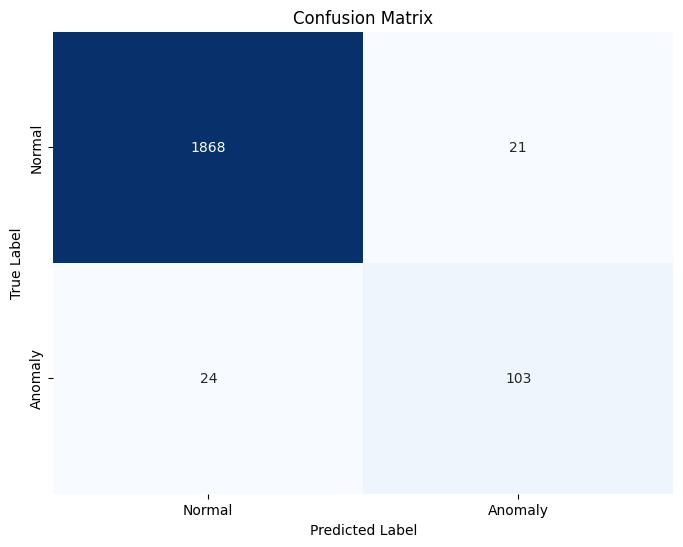

In [907]:
cm = confusion_matrix(targets, final_predictions)

TN, FP, FN, TP = cm.ravel()
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
print("False Positive Rate:", FPR)

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()